In [1]:
import pandas as pd
from datetime import datetime as dt
import re
import gensim
import copy
# to save LDA model to disk
from gensim.test.utils import datapath

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

In [2]:
# test package import
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

import os

# for object serialization
import pickle

# plot correlation matrix
import seaborn as sns

############ data cleaning ###############################
## get nltk toolbox, e.g. to remove english stop words
import nltk
from nltk.corpus import stopwords
# uncomment this to download nltk dictionaries
# to install nltk, go to https://www.nltk.org/
#nltk.download()
import os as _os
# to set the path of the downloaded dictionary
from nltk.data import path as nltk_path
nltk_path.append( '../nltk_data')
# downloading stopwords for english
nltk.download('stopwords')
print(stopwords.words('english'))
# differentiating the different word tags
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
# for stemming
from nltk.stem.porter import PorterStemmer

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [130]:
## GLOBAL VARIABLES ##

# if false, will load existing model from disk
run_lda_model = True
# if false, will re-run boe minutes pre-processing
# otherwise, will load from serialized folder below
load_saved_boe_data = True
# if true, will save down figures to disk in image folder
save_figures = True
# if true, uncertainty will be based on the sum of tf-idf
uncertainty_from_tfidf = True

image_dir = "./images/"
serialized_dir = 'serialized_data/'
does_exist = os.path.exists(image_dir)
if not does_exist:
   # Create "images" directory because it does not exist
   os.makedirs(image_dir)
   print("images directory created!")


does_exist = os.path.exists(serialized_dir)
if not does_exist:
   # Create "images" directory because it does not exist
   os.makedirs(serialized_dir)
   print("serialization directory created!")


In [5]:
# papers

# FOMC analysis
# https://medium.com/@nusfintech.ml/nlp-on-fomc-meetings-50b48c447fe1
# https://highdemandskills.com/topic-trends-fomc/
# quoted from FOMC guys:
# https://highdemandskills.com/topic-modeling-lda/
# the main on LDA:
# https://highdemandskills.com/topic-modeling-lda/#h3-3
# medium on LDA:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
# coherence measure:
# https://radimrehurek.com/gensim/models/coherencemodel.html
# LSA vs LDA topic modelling
# https://www.datacamp.com/tutorial/what-is-topic-modeling
# coherence and perplexity, finding the number of topics
# https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920


In [78]:
def save_data_serialized(obj_to_save, name_of_file):
    fileObj = open('serialized_data/'+name_of_file+'.obj', 'wb')
    pickle.dump(obj_to_save,fileObj)
    fileObj.close()


def load_serialized_data(obj_names):
    objects = []
    for obj_name in obj_names:
        fileObj = open('serialized_data/'+obj_name+'.obj', 'rb')
        objects.append(pickle.load(fileObj))
        fileObj.close()
    return objects

def flatten(xss):
    return [x for xs in xss for x in xs]

def preprocessing(docs_full_text, doc_name, drop_na=True, min_doc_char_count = 100):
    '''
    Preprocessing the data, removing stop words and words without
    too much semantic attached (e.g. prepositions) and performing 
    stemming
    '''
    # Clean text - stage 1
    cleaning_full_text = docs_full_text.strip()  # Remove white space at the beginning and end
    cleaning_full_text = cleaning_full_text.replace('\r', '') # Replace the \r with null
    while '  ' in cleaning_full_text:
        cleaning_full_text = cleaning_full_text.replace('  ', ' ') # Remove extra spaces
        cleaning_full_text = re.sub(r'(<[^>]*>)|' # Remove content within HTML tags
                        '([_]+)|' # Remove series of underscores
                        '(http[^\s]+)|' # Remove website addresses
                        '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                        '', cleaning_full_text) # Replace with null
    ## Removing symbols and urls
    
    # removing urls
    #docs_cleaning = docs_cleaning.str.replace(r'^https?:\/\/.*[\r\n]*', '')
    #docs_cleaning = docs_cleaning.str.replace("https?","")
    #docs_cleaning = docs_cleaning.str.replace("www.*com","")
    cleaning_full_text = re.sub('\n *\d+ *\n', '\n', cleaning_full_text, flags=re.DOTALL)
    cleaning_full_text  = str.lower(cleaning_full_text)
    cleaning_full_text = re.sub('(.*)(?=before turning)', '', cleaning_full_text, flags=re.DOTALL)
    # the last paragraph is ignored
    cleaning_full_text = re.findall('\n\d+[:)\.]? (.+?)(?=\.?\n\n\d|\.?\n\n|\.?\n\d+ )', cleaning_full_text, flags=re.DOTALL)

    docs_cleaning = pd.Series(cleaning_full_text)
    # removing fractions
    docs_cleaning = docs_cleaning.str.replace("[0-9]*\/[0-9]*","")
    # removing group of numbers
    docs_cleaning = docs_cleaning.str.replace("[0-9]+","")
    # remove characters/numbers at beginning
    docs_cleaning = docs_cleaning.str.replace("[^A-Za-z0-9]", " ")
    # remove multi-spaces for one space
    docs_cleaning = docs_cleaning.str.replace("\s+"," ")
    # Removing Stopwords from English Dictionary 
    stop_words = set(stopwords.words('english'))
    # remove recipes that are NA
    if drop_na:
        docs_cleaning = docs_cleaning[~docs_cleaning.isna()]
    docs_cleaning.reset_index(drop=True, inplace=True)
    # Tokenization
    docs_tok = docs_cleaning.apply(lambda x: x.split())
    # Stemming
    stemmer = PorterStemmer()
    #docs_tok = docs_tok.apply(lambda x: [stemmer.stem(i) for i in x if i not in stop_words]) # stemming
    fun_exclude = lambda tag: (tag[1] not in ['MD','CD','CC','DT','EX','IN','LS','MD','NNP',
                                            'PDT','POS','PRP','PRP$','TO','UH',
                                            'WDT','WP','WRB', 'RP']) and (tag[0] not in stop_words)
    docs_tok = docs_tok.apply(lambda doc_line: [stemmer.stem(tag[0]) for tag in pos_tag(doc_line) if fun_exclude(tag)]) # stemming
    # filter docs that do not meet min length
    docs_tok_filtered = docs_tok[docs_tok.apply(lambda x: len("".join(x)) > min_doc_char_count).values]
    # compute document weights in sub-corpus (for a given meeting date)
    corpusdate_total_weight = docs_tok_filtered.apply(lambda x: 1/len("".join(x))).sum()
    docs_weight = [[doc_name,weight] for weight in docs_tok_filtered.apply(lambda x: 1/len("".join(x))/corpusdate_total_weight).to_list()]
    # rejoin the sentence
    docs_cleaning = docs_tok_filtered.apply(lambda x: " ".join(x))
    # check the result of cleaning
    # print(docs_cleaning.head())
    docs_cleaning.to_csv("clean_boe_files/"+doc_name+"_clean.csv")
    # returns full documents and tokenized version
    docs_tok_filtered_aslist = docs_tok_filtered.to_list()
    all_words = flatten(docs_tok_filtered.to_list())
    # tokens list per document (list of lists): docs_tok_filtered_aslist
    # all words as one big list (not unique): all_words
    # list of couple (minutes date, doc weight): docs_weight 
    return docs_tok_filtered_aslist, all_words, docs_weight, cleaning_full_text

In [80]:
## all minutes dates sorted from old to new
boe_dates = pd.read_csv("boe_meeting_dates.txt").apply(lambda x: dt.strptime(x["date"], "%d-%b-%y"),axis=1)
dates_dt = np.flip([a_date.date() for a_date in boe_dates])
dates_str = np.flip([a_date.date().strftime("%Y-%m-%d") for a_date in boe_dates])#.strftime("%d-%m-%Y")
dates_indices = np.argsort(dates_dt)
#boe_dates
#np.flip(dates_str)
dates_str       = dates_str[dates_indices]
dates_dt        = dates_dt[dates_indices]
dates_dt64      = list(map(lambda x: np.datetime64(x),dates_dt))
date_str_dt     = dict(zip(dates_str, dates_dt))
date_str_dt64   = dict(zip(dates_str, dates_dt64))

dates_str

array(['2007-12-06', '2008-01-10', '2008-02-07', '2008-03-06',
       '2008-04-10', '2008-05-08', '2008-06-05', '2008-07-10',
       '2008-08-07', '2008-09-04', '2008-10-08', '2008-11-06',
       '2008-12-04', '2009-01-08', '2009-02-05', '2009-03-05',
       '2009-04-09', '2009-05-07', '2009-06-04', '2009-07-09',
       '2009-08-06', '2009-09-10', '2009-10-08', '2009-11-05',
       '2009-12-10', '2010-01-07', '2010-02-04', '2010-03-04',
       '2010-04-08', '2010-05-10', '2010-06-10', '2010-07-08',
       '2010-08-05', '2010-09-09', '2010-10-07', '2010-11-04',
       '2010-12-09', '2011-01-13', '2011-02-10', '2011-03-10',
       '2011-04-07', '2011-05-05', '2011-06-09', '2011-07-07',
       '2011-08-04', '2011-09-08', '2011-10-06', '2011-11-10',
       '2011-12-08', '2012-01-12', '2012-02-09', '2012-03-08',
       '2012-04-05', '2012-05-10', '2012-06-07', '2012-07-05',
       '2012-08-02', '2012-09-06', '2012-10-04', '2012-11-08',
       '2012-12-06', '2013-01-10', '2013-02-07', '2013-

In [81]:
def process_file(date_str):
    print(f"processing minutes from {date_str}")
    file_name = "raw_boe_files/"+date_str+"_boe_minutes.txt"
    infile = open(file_name, 'r')
    data = infile.read()
    infile.close()
    return preprocessing(data, date_str)

def process_large_file(file_name):
    infile = open(os.getcwd()+"\\"+file_name, 'r')
    all_minutes_txt = infile.read()
    infile.close()
    without_headers = re.sub(r'\n\d+-\d+-\d+_boe_minutes\n', '', all_minutes_txt)
    minutes_split = re.split("\*"*50, without_headers)[1:]
    return minutes_split

if not(load_saved_boe_data):
    minutes_split = process_large_file("boe_all_minutes.txt")
    docs_tokens_list, all_words, docs_weight, series_ft = preprocessing(minutes_split[0],dates_str[0])
    for date_index in range(1,len(dates_str)):
        print(f"processing minutes from {dates_str[date_index]}")
        outputs = preprocessing(minutes_split[date_index],dates_str[date_index])
        docs_tokens_list = docs_tokens_list + outputs[0]
        all_words = all_words + outputs[1]
        docs_weight = docs_weight + outputs[2]

    save_data_serialized(docs_tokens_list,"docs_tok_filtered_aslist")
    save_data_serialized(all_words,"all_words")
    save_data_serialized(docs_weight,"docs_weight")
else:
    saved_data_list = load_serialized_data(["docs_tok_filtered_aslist","all_words","docs_weight"])
    docs_tokens_list            = saved_data_list[0]
    all_words                   = saved_data_list[1]
    docs_weight                 = saved_data_list[2]


processing minutes from 2008-01-10
processing minutes from 2008-02-07
processing minutes from 2008-03-06
processing minutes from 2008-04-10
processing minutes from 2008-05-08
processing minutes from 2008-06-05
processing minutes from 2008-07-10
processing minutes from 2008-08-07
processing minutes from 2008-09-04
processing minutes from 2008-10-08
processing minutes from 2008-11-06
processing minutes from 2008-12-04
processing minutes from 2009-01-08
processing minutes from 2009-02-05
processing minutes from 2009-03-05
processing minutes from 2009-04-09
processing minutes from 2009-05-07
processing minutes from 2009-06-04
processing minutes from 2009-07-09
processing minutes from 2009-08-06
processing minutes from 2009-09-10
processing minutes from 2009-10-08
processing minutes from 2009-11-05
processing minutes from 2009-12-10
processing minutes from 2010-01-07
processing minutes from 2010-02-04
processing minutes from 2010-03-04
processing minutes from 2010-04-08
processing minutes f

In [89]:
# Form dictionary by mapping word IDs to words
id2word = corpora.Dictionary(docs_tokens_list)

In [90]:
# Set up Bag of Words and TFIDF
corpus = [id2word.doc2bow(doc) for doc in docs_tokens_list] # Apply Bag of Words to all documents in corpus
tfidf = models.TfidfModel(corpus) # Fit TF-IDF model
corpus_tfidf = tfidf[corpus] # Apply TF-IDF model

In [123]:
len(corpus_tfidf)

6367

In [60]:
count_word

310748

In [126]:
def load_file(file_name):
    print(f"processing file {file_name}")
    infile = open(file_name, 'r')
    data = infile.read()
    infile.close()
    return data


id2word_with_uncertainty = copy.deepcopy(id2word)
# adding the uncertainty word list to our dictionary
uncertainty_words = load_file("uncertainty_words_finlex_plus_lm.txt").split("\n")
id2word_with_uncertainty.add_documents([uncertainty_words])
uncertainty_indices = [bow[0] for bow in id2word_with_uncertainty.doc2bow(uncertainty_words)]
uncertainty_score = np.zeros(len(corpus))
if uncertainty_from_tfidf:
    for i in range(len(corpus)):
        uncertainty_score[i] = np.sum([tfidf[1] for tfidf in corpus_tfidf[i] if tfidf[0] in uncertainty_indices])
else:
    for i in range(len(corpus)):
        uncertainty_score[i] = np.sum([bow[1] for bow in corpus[i] if bow[0] in uncertainty_indices])
#ID2word.id2token[174]
#len(ID2word.doc2bow(load_file("uncertainty_words_finlex_plus_lm.txt").split("\n")))

processing file uncertainty_words_finlex_plus_lm.txt


In [132]:
uncertainty_score2 = np.zeros(len(corpus))
for i in range(len(corpus)):
        uncertainty_score2[i] = np.sum([bow[1] for bow in corpus[i] if bow[0] in uncertainty_indices])

In [131]:
uncertainty_score[0:30]

array([1.0220012 , 0.55467257, 0.17546579, 0.91525752, 0.15420837,
       0.16604236, 0.05814438, 0.27301285, 0.09242804, 0.17058841,
       0.60321661, 0.23431894, 0.30097577, 0.10772858, 0.09567204,
       0.67264029, 0.50750059, 0.3515823 , 0.27615813, 0.        ,
       0.28021799, 0.41674128, 0.15031892, 0.44059808, 0.7004721 ,
       0.40998662, 0.78337033, 0.34354339, 0.37172259, 1.07489481])

In [134]:
uncertainty_score2[0:30]

array([ 8., 10.,  2.,  9.,  2.,  2.,  1.,  2.,  1.,  2.,  6.,  3.,  4.,
        1.,  1.,  7.,  5.,  4.,  5.,  0.,  5.,  6.,  1.,  5.,  8.,  5.,
        8.,  5.,  3., 12.])

In [10]:
len(docs_tokens_list)

6367

In [11]:
def run_lda(corpus, id2word, num_topics = 6, passes = 100, alpha = 0.125, eta = 0.125, general_seed = 30224, lda_seed = 130):
    np.random.seed(general_seed)
    eta_array_best = np.array([eta]*len(list(id2word.token2id))) # Set eta
    Lda = gensim.models.ldamodel.LdaModel
    lda_model = Lda(corpus, num_topics = num_topics, \
                id2word = id2word, passes= passes, 
                random_state=lda_seed,
                alpha=alpha,eta=eta)
    cm = gensim.models.coherencemodel.CoherenceModel(\
            model=lda_model, texts=docs_tokens_list,\
            dictionary=id2word, coherence='c_v')
    coherence_score = cm.get_coherence()
    # print coherence score and perplexity
    print('-'*50)
    print('\nCoherence Score:', coherence_score)
    print('-'*50)
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
    return (lda_model,coherence_score)

lda_model, coherence = run_lda(corpus_tfidf, id2word,1,1)
pprint(lda_model.print_topics(num_words=15))

--------------------------------------------------

Coherence Score: 0.33922989182792784
--------------------------------------------------

Perplexity:  -8.427206305007712
[(0,
  '0.006*"inflat" + 0.005*"expect" + 0.005*"price" + 0.004*"cpi" + '
  '0.004*"rate" + 0.004*"polici" + 0.004*"growth" + 0.004*"bank" + '
  '0.004*"monetari" + 0.004*"increas" + 0.003*"remain" + 0.003*"market" + '
  '0.003*"gdp" + 0.003*"servic" + 0.003*"mpc’"')]


In [42]:
## best parameters LDA ##

lda_seed = 400 # Set random seed
num_topics_best = 6 # Set number of topics
alpha_best = 0.15 # Set alpha
eta_best = 0.32
eta_array_best = np.array([eta_best]*len(list(id2word.token2id))) # Set eta
num_passes_best = 700

In [43]:
## run best LDA model ## 

lda_model, coherence = run_lda(corpus_tfidf, id2word,
                               num_topics=num_topics_best,
                               passes=num_passes_best,
                               alpha=alpha_best,
                               eta=eta_best,
                               lda_seed=lda_seed)
pprint(lda_model.print_topics(num_words=15))


--------------------------------------------------

Coherence Score: 0.682685722466319
--------------------------------------------------

Perplexity:  -8.630911105287975
[(0,
  '0.000*"administrations." + 0.000*"journey" + 0.000*"pre-omicron" + '
  '0.000*"relaxations," + 0.000*"removals," + 0.000*"reservations," + '
  '0.000*"high-contact" + 0.000*"flight" + 0.000*"devolv" + 0.000*"train" + '
  '0.000*"restaur" + 0.000*"track" + 0.000*"card" + 0.000*"week" + '
  '0.000*"high-frequ"'),
 (1,
  '0.006*"rate" + 0.006*"yield" + 0.005*"bond" + 0.005*"unit" + 0.005*"market" '
  '+ 0.005*"equiti" + 0.005*"basi" + 0.004*"interest" + 0.004*"govern" + '
  '0.004*"sterl" + 0.004*"previou" + 0.004*"meeting," + 0.004*"euro" + '
  '0.003*"mpc’" + 0.003*"uk"'),
 (2,
  '0.000*"fco" + 0.000*"carers," + 0.000*"professionals," + 0.000*"volunt" + '
  '0.000*"effort" + 0.000*"citizen" + 0.000*"combat" + 0.000*"front" + '
  '0.000*"country," + 0.000*"extraordinari" + 0.000*"nh" + 0.000*"compris" + '
  '0.0

In [44]:
temp_file = datapath(os.getcwd()+"\\"+"lda_model_39")
lda_model.save(temp_file)

In [92]:
from gensim import  models

lda = models.ldamodel.LdaModel.load(os.getcwd()+"\\"+"lda_model_best")
pprint(lda.print_topics(num_words=15))

[(0,
  '0.000*"purpos" + 0.000*"fall-back" + 0.000*"forcefully," + 0.000*"monetari" '
  '+ 0.000*"polici" + 0.000*"uk" + 0.000*"12-month" + 0.000*"held" + '
  '0.000*"paramet" + 0.000*"bond" + 0.000*"septemb" + 0.000*"needed," + '
  '0.000*"compris" + 0.000*"vote" + 0.000*"billion,"'),
 (1,
  '0.000*"purpos" + 0.000*"fall-back" + 0.000*"forcefully," + 0.000*"monetari" '
  '+ 0.000*"polici" + 0.000*"uk" + 0.000*"12-month" + 0.000*"held" + '
  '0.000*"paramet" + 0.000*"bond" + 0.000*"septemb" + 0.000*"needed," + '
  '0.000*"compris" + 0.000*"vote" + 0.000*"billion,"'),
 (2,
  '0.000*"purpos" + 0.000*"fall-back" + 0.000*"forcefully," + 0.000*"monetari" '
  '+ 0.000*"polici" + 0.000*"uk" + 0.000*"12-month" + 0.000*"held" + '
  '0.000*"paramet" + 0.000*"bond" + 0.000*"septemb" + 0.000*"needed," + '
  '0.000*"compris" + 0.000*"vote" + 0.000*"billion,"'),
 (3,
  '0.000*"purpos" + 0.000*"fall-back" + 0.000*"forcefully," + 0.000*"monetari" '
  '+ 0.000*"polici" + 0.000*"uk" + 0.000*"12-month" +

In [101]:
### LSA attempt ###

from gensim.models import LsiModel

num_lsa_topics = 13
# LSA model
lsa = LsiModel(corpus=corpus_tfidf, num_topics=num_lsa_topics, id2word = id2word, random_seed=lda_seed)

# LSA model
pprint(lsa.print_topics(num_topics=num_lsa_topics, num_words=15))

[(0,
  '0.208*"inflat" + 0.142*"growth" + 0.130*"rate" + 0.130*"expect" + '
  '0.128*"price" + 0.112*"bank" + 0.102*"remain" + 0.101*"increas" + '
  '0.099*"cpi" + 0.097*"polici" + 0.096*"market" + 0.096*"committe" + '
  '0.092*"gdp" + 0.087*"like" + 0.086*"unit"'),
 (1,
  '0.394*"vote" + 0.250*"maintain" + 0.238*"proposit" + 0.220*"bank" + '
  '0.212*"favour" + 0.208*"purchas" + 0.204*"stock" + 0.179*"unanim" + '
  '0.172*"asset" + 0.163*"issuanc" + 0.155*"committe" + 0.155*"financ" + '
  '0.153*"regard" + 0.142*"proposition." + 0.140*"invit"'),
 (2,
  '0.357*"inflat" + 0.216*"cpi" + 0.186*"target" + -0.182*"gdp" + '
  '-0.169*"growth" + 0.126*"price" + -0.126*"output" + -0.119*"survey" + '
  '-0.117*"invest" + -0.117*"quarter" + -0.112*"estim" + -0.111*"busi" + '
  '0.107*"polici" + -0.107*"indic" + 0.103*"medium"'),
 (3,
  '0.220*"bond" + -0.199*"inflat" + 0.193*"yield" + -0.180*"pay" + '
  '-0.173*"cpi" + -0.158*"vote" + 0.151*"govern" + 0.149*"interest" + '
  '0.147*"equiti" + 0.1

In [162]:
para_no = 0 # Set document counter
docs_subcorpus_topic_weight = copy.deepcopy(docs_weight)
for para in docs_weight:
    TFIDF_para = tfidf[corpus[para_no]] # Apply TFIDF model to individual minutes documents
    # Generate and store weighted topic proportions for each para
    for topic_weight in lda_model.get_document_topics(TFIDF_para): # List of tuples ("topic number", "topic proportion") for each para, where 'topic_weight' is the (iterating) tuple
        docs_subcorpus_topic_weight[para_no].append(docs_weight[para_no][1]*topic_weight[1]) # Weights are the second element of the pre-appended list, topic proportions are the second element of each tuple
    para_no += 1
#main_topics = ['Inflation', 'Market', 'Growth', 'Employment', 
#               'Geopolitics', 'Policy', 'Consumption', 'Operation']

main_topics = ['Credit Consumption', 'Growth', 'Inflation', 'Policy Decision', 
               'Financial Market', 'Governors']

main_topics = ['General News', 'Financial Markets', 'Other News', 'Inflation', 
               'Policy Decision', 'Growth']

#main_topics = list(map(str,list(np.arange(0,num_topics_best))))

#main_topics = ['Policy', 'Market', 'Geopolitics', 'Inflation', 
#               'Consumption', 'Growth', 'Wages', 'Operation']

# Form dataframe of weighted topic proportions (paragraphs) - include any chosen topic names
FOMCTopixDF = pd.DataFrame(docs_subcorpus_topic_weight, columns=['Date_str', 'Weight']+main_topics)
FOMCTopixDF['Date_dt'] = FOMCTopixDF.apply(lambda x:date_str_dt[x['Date_str']],axis=1)
FOMCTopixDF['Date_dt64'] = FOMCTopixDF.apply(lambda x:date_str_dt64[x['Date_str']],axis=1)

FOMCTopixDF['Uncertainty Score'] = uncertainty_score

# Aggregate topic mix by minutes documents (weighted sum of paragraphs)
TopixAggDF = pd.pivot_table(FOMCTopixDF, values=main_topics+['Uncertainty Score'], index='Date_dt64', aggfunc=np.sum)

C:\Users\guill\AppData\Local\Temp\ipykernel_40564\2122918653.py:31: FutureWarning: The provided callable <function sum at 0x0000021A7E8D9820> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  TopixAggDF = pd.pivot_table(FOMCTopixDF, values=main_topics+['Uncertainty Score'], index='Date_dt64', aggfunc=np.sum)


In [163]:
oidx = TopixAggDF.index
nidx = pd.date_range(TopixAggDF.index.min(), TopixAggDF.index.max(), freq='M')
TopixAggDF_reind = TopixAggDF.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)
#TopixAggDF[["Consumption","Employment"]].resample('D',convention='s').interpolate(method='linear').resample('M').interpolate(method='linear')
#TopixAggDF[["Consumption","Employment"]].resample('M').interpolate(method='linear')
TopixAggDF_reind

Financial Markets  General News    Growth  Inflation  Other News  \
2007-12-31           0.147722      0.023962  0.497898   0.282409    0.023962   
2008-01-31           0.169843      0.023734  0.441115   0.296033    0.023734   
2008-02-29           0.154022      0.023410  0.373640   0.366801    0.023410   
2008-03-31           0.147338      0.023722  0.429243   0.325508    0.023722   
2008-04-30           0.096413      0.023852  0.470345   0.333893    0.023852   
...                       ...           ...       ...        ...         ...   
2023-07-31           0.038802      0.025268  0.275502   0.469294    0.025268   
2023-08-31           0.066112      0.025089  0.304958   0.403766    0.025089   
2023-09-30           0.083912      0.025014  0.298692   0.375227    0.025014   
2023-10-31           0.059071      0.025093  0.200013   0.445409    0.025093   
2023-11-30           0.087197      0.024836  0.274056   0.439200    0.024836   

            Policy Decision  Uncertainty Score  
2007-12-31         0.024046          11.921631  
2008-01-31         0.045542          13.413592  
2008-02-29         0.058717          13.818606  
2008-03-31         0.050468          15.397058  
2008-04-30         0.051646          12.017928  
...                     ...                ...  
2023-07-31         0.165866           8.389183  
2023-08-31         0.174987          12.065892  
2023-09-30         0.192140          13.659528  
2023-10-31         0.245320           9.010862  
2023-11-30         0.149876          11.505180  

[192 rows x 7 columns]

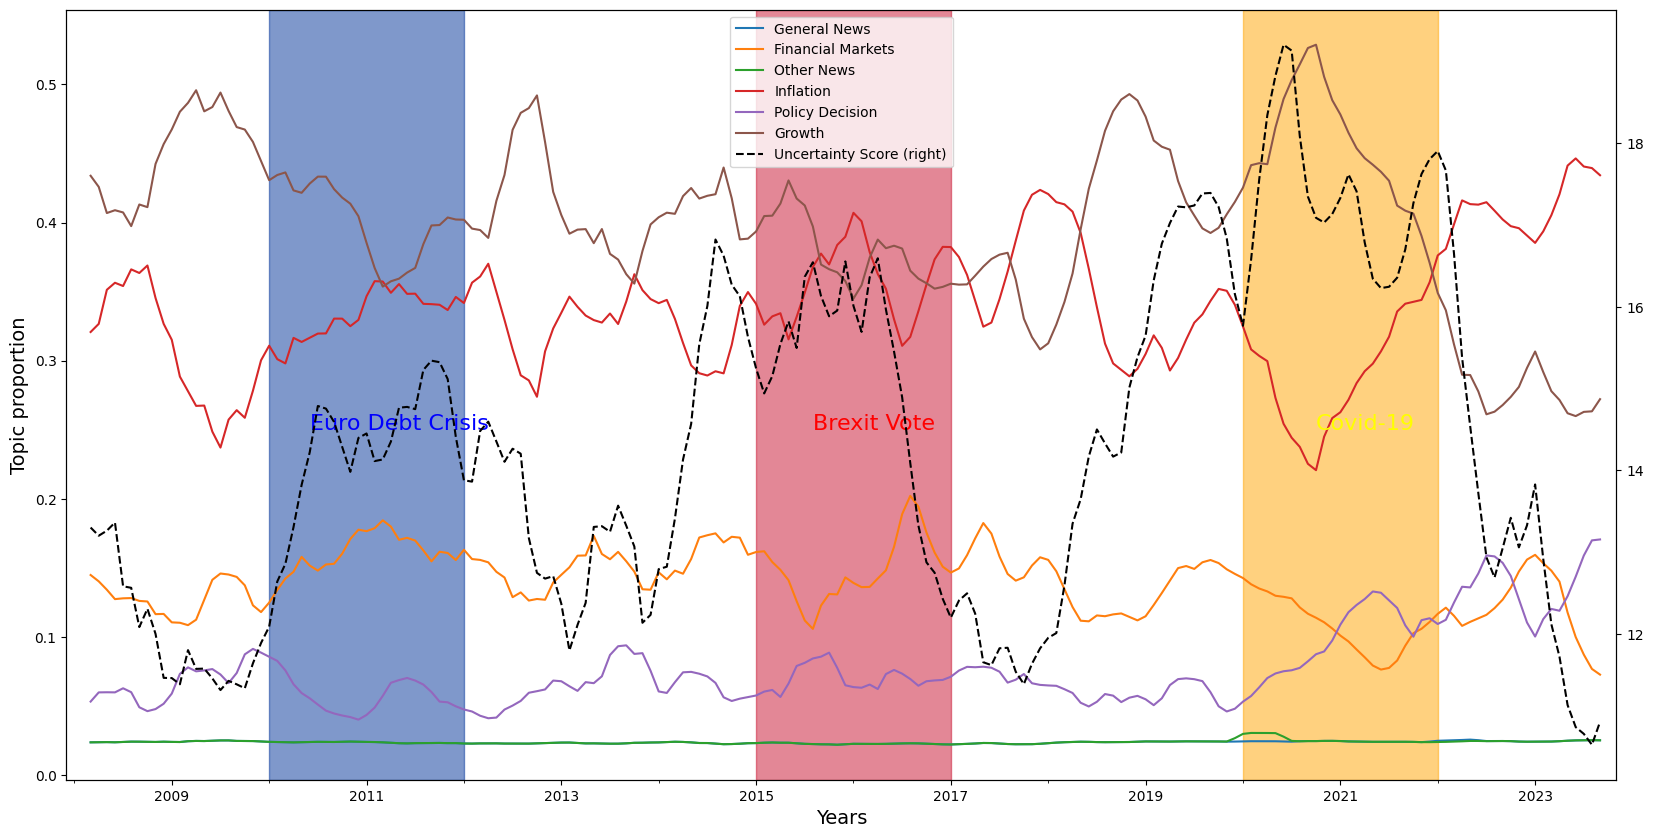

In [179]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame


TopixAggDFMean = TopixAggDF_reind.rolling(6, center=True).mean()
fig, ax = plt.subplots(figsize=(20,10)) 
ax.legend(main_topics+['Uncertainty Score'],fontsize=30)
TopixAggDFMean.plot(y = main_topics, ax = ax)
ax.legend(main_topics+['Uncertainty Score'],fontsize=14)
#ax.legend.get_frame().set_alpha(None)
#leg = ax.legend( alpha=0.2)
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
TopixAggDFMean.plot(y = 'Uncertainty Score', ax = ax, secondary_y = True, style = '--', color = 'black') 
ax2 = ax.twinx()
ax.axvspan(np.datetime64(dt(2010,1,1)), np.datetime64(dt(2012,1,1)), alpha=0.5, color='#003399')
ax.axvspan(np.datetime64(dt(2015,1,1)), np.datetime64(dt(2017,1,1)), alpha=0.5, color='#C8102E')
ax.axvspan(np.datetime64(dt(2020,1,1)), np.datetime64(dt(2022,1,1)), alpha=0.5, color='orange')
ax.set_xlabel('Years', fontsize=14);
ax.set_ylabel('Topic proportion', fontsize=14);
ax.annotate('Euro Debt Crisis',
            xy=(np.datetime64(dt(2010,6,1)), 0.25), xycoords='data',color='blue', fontsize=16)
ax.annotate('Brexit Vote',
            xy=(np.datetime64(dt(2015,8,1)), 0.25), xycoords='data',color='red', fontsize=16)
ax.annotate('Covid-19',
            xy=(np.datetime64(dt(2020,10,1)), 0.25), xycoords='data',color='yellow', fontsize=16)
ax2.axis('off')
ax2.set_ylabel('Uncertainty Score', fontsize=14);
#fig.legend(edgecolor="black")
#fig.legend.get_frame().set_alpha(None)
if save_figures:
    fig.savefig(\
        image_dir+"topics_over_time.png",\
            bbox_inches='tight')

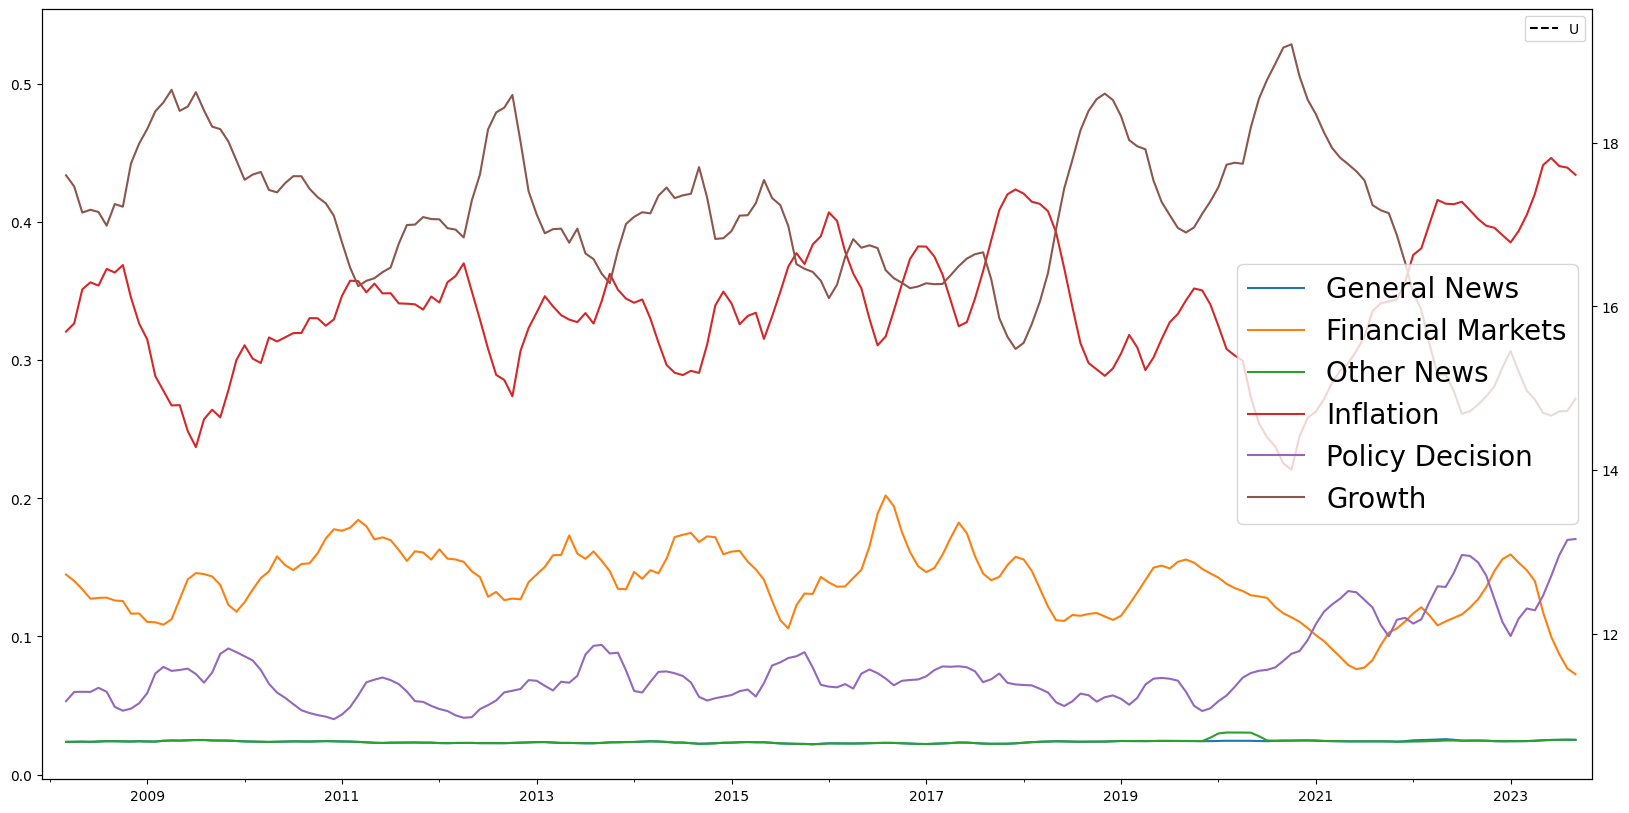

In [197]:
TopixAggDFMean = TopixAggDF_reind.rolling(6, center=True).mean()
fig, ax = plt.subplots(figsize=(20,10)) 
TopixAggDFMean.plot(y = main_topics, ax = ax, label=main_topics)

#ax.legend.get_frame().set_alpha(None)
#leg = ax.legend( alpha=0.2)
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)


ax2 = ax.twinx()
ax2.plot(TopixAggDFMean['Uncertainty Score'], '--', color = 'black', label='Uncertainty Score') 
ax.legend(main_topics,fontsize=20)
ax2.legend('Uncertainty Score',loc='best')

Text(0.5, 1.0, 'Topic Proportions over Time')

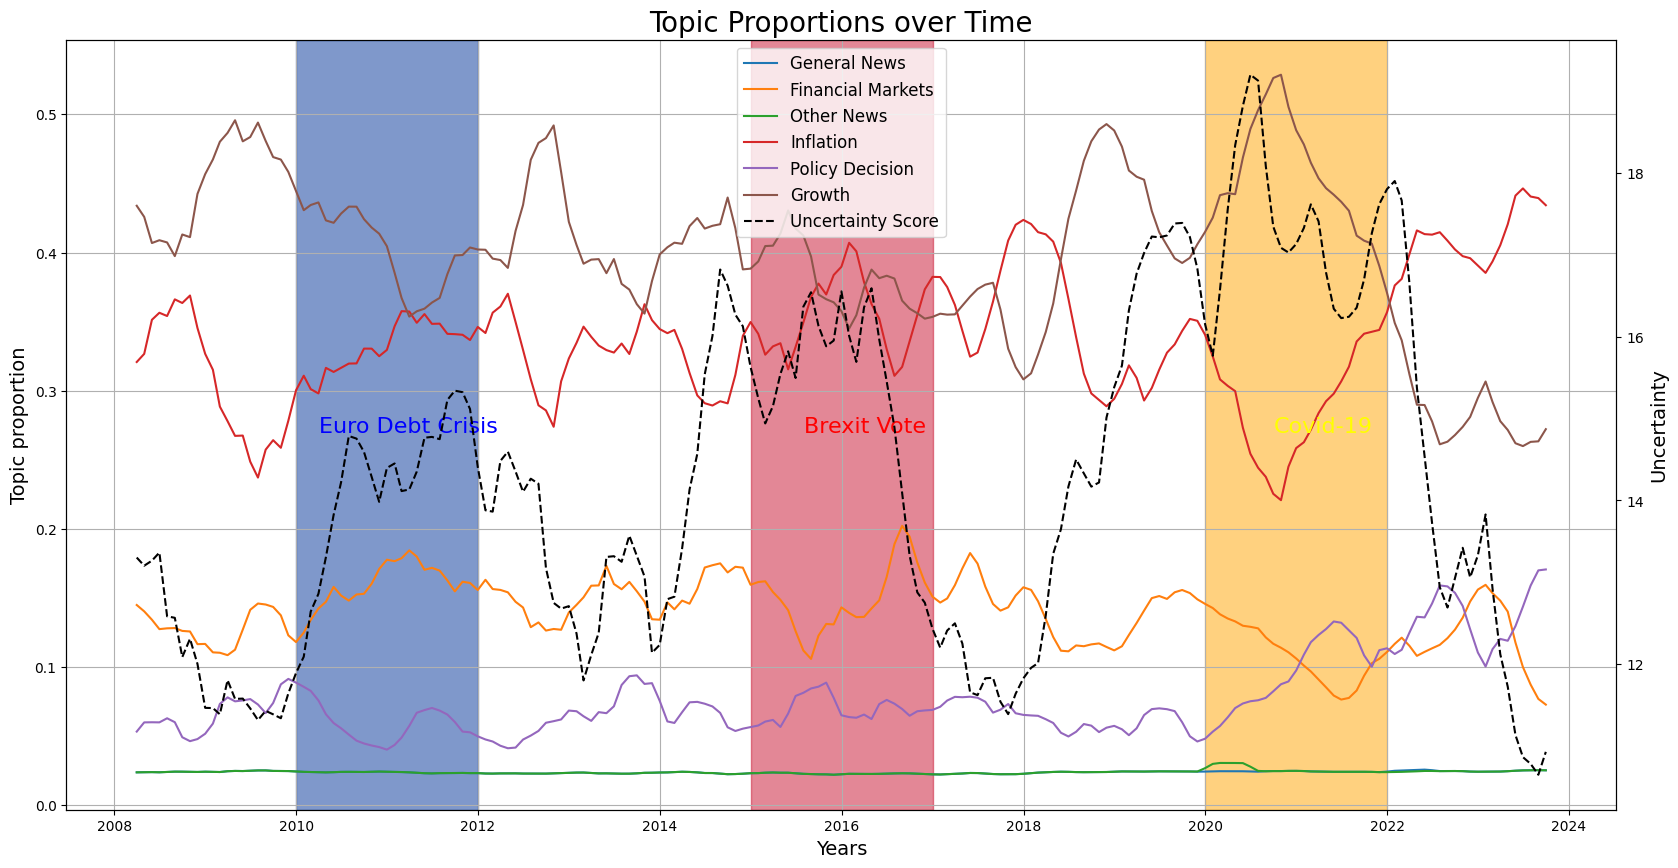

In [235]:
fig, ax = plt.subplots(figsize=(20,10)) 
ax.grid()
lns1 = ax.plot(TopixAggDFMean[main_topics[0]], label=main_topics[0])
for topic in main_topics[1:]:
    lns1 += ax.plot(TopixAggDFMean[topic], label=topic)

ax2 = ax.twinx()
#ax2.grid(linestyle=':', linewidth=0.7, color = 'b')
lns1 += ax2.plot(TopixAggDFMean['Uncertainty Score'], '--', color = 'black', label='Uncertainty Score') 
labs = [l.get_label() for l in lns1]
ax.legend(lns1, labs, loc='best', fontsize=12)
ax.axvspan(np.datetime64(dt(2010,1,1)), np.datetime64(dt(2012,1,1)), alpha=0.5, color='#003399')
ax.axvspan(np.datetime64(dt(2015,1,1)), np.datetime64(dt(2017,1,1)), alpha=0.5, color='#C8102E')
ax.axvspan(np.datetime64(dt(2020,1,1)), np.datetime64(dt(2022,1,1)), alpha=0.5, color='orange')
ax.set_xlabel('Years', fontsize=14);
ax.set_ylabel('Topic proportion', fontsize=14);
ax2.set_ylabel('Uncertainty', fontsize=14);
ax.annotate('Euro Debt Crisis',
            xy=(np.datetime64(dt(2010,4,1)), 0.27), xycoords='data',color='blue', fontsize=16)
ax.annotate('Brexit Vote',
            xy=(np.datetime64(dt(2015,8,1)), 0.27), xycoords='data',color='red', fontsize=16)
ax.annotate('Covid-19',
            xy=(np.datetime64(dt(2020,10,1)), 0.27), xycoords='data',color='yellow', fontsize=16)
plt.title('Topic Proportions over Time', fontsize=20)

if save_figures:
    fig.savefig(\
        image_dir+"topics_over_time.png",\
            bbox_inches='tight')

In [153]:
n_words = np.shape(lda_model.get_topics())[1]
best_topic_perword = [np.where(lda_model.get_topics()[:,i] == np.max(lda_model.get_topics()[:,i]))[0][0] for i in range(0,n_words)]

In [154]:
from sklearn.manifold import TSNE
tsne_term_topic_model = TSNE(n_components=2, perplexity=50, learning_rate=50, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_terms_topics = tsne_term_topic_model.fit_transform(lda_model.get_topics().T)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9548 samples in 0.011s...
[t-SNE] Computed neighbors for 9548 samples in 0.363s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9548
[t-SNE] Computed conditional probabilities for sample 2000 / 9548
[t-SNE] Computed conditional probabilities for sample 3000 / 9548
[t-SNE] Computed conditional probabilities for sample 4000 / 9548
[t-SNE] Computed conditional probabilities for sample 5000 / 9548
[t-SNE] Computed conditional probabilities for sample 6000 / 9548
[t-SNE] Computed conditional probabilities for sample 7000 / 9548
[t-SNE] Computed conditional probabilities for sample 8000 / 9548
[t-SNE] Computed conditional probabilities for sample 9000 / 9548
[t-SNE] Computed conditional probabilities for sample 9548 / 9548
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.226078
[t-SNE] KL divergence after 2000 iterations: 0.577183


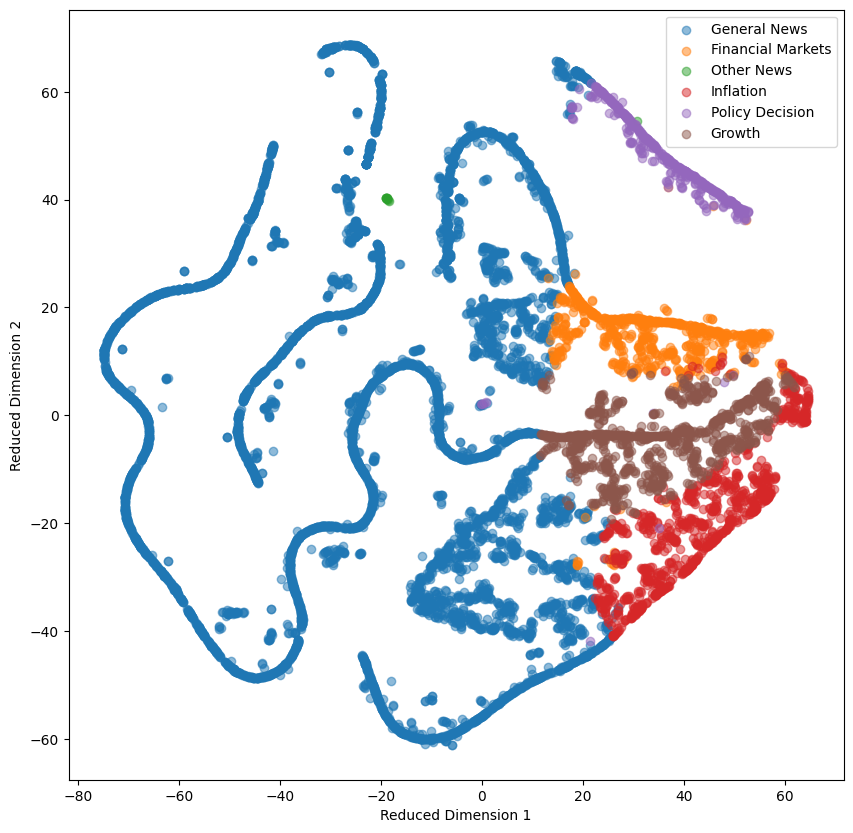

In [200]:
fig, ax = plt.subplots(figsize=(10,10)) 
for i in range(len(main_topics)):
    plt.scatter(tsne_terms_topics[np.array(best_topic_perword)==i, 0], tsne_terms_topics[np.array(best_topic_perword)==i, 1], alpha=0.5, label=main_topics[i])
ax.set_xlabel('Reduced Dimension 1');
ax.set_ylabel('Reduced Dimension 2');
plt.legend()
plt.show()

if save_figures:
    fig.savefig(\
        image_dir+"words_topic.png",\
            bbox_inches='tight')


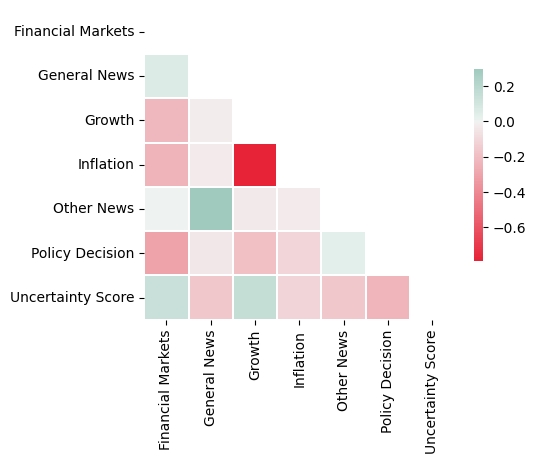

In [224]:
TopixAggDF_returns = TopixAggDFMean.shift(1)-TopixAggDFMean
#TopixAggDF.rolling(6).mean().corr()
corr_matrix = TopixAggDF_returns.corr()

#corr_matrix_short = corr_matrix.drop("Governors",axis=1)
#corr_matrix_short = corr_matrix_short.drop("Governors",axis=0)
#corr_matrix_short

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 160, s=90, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5})
if save_figures:
    fig.savefig(\
        image_dir+"topics_correlation.png",\
            bbox_inches='tight')

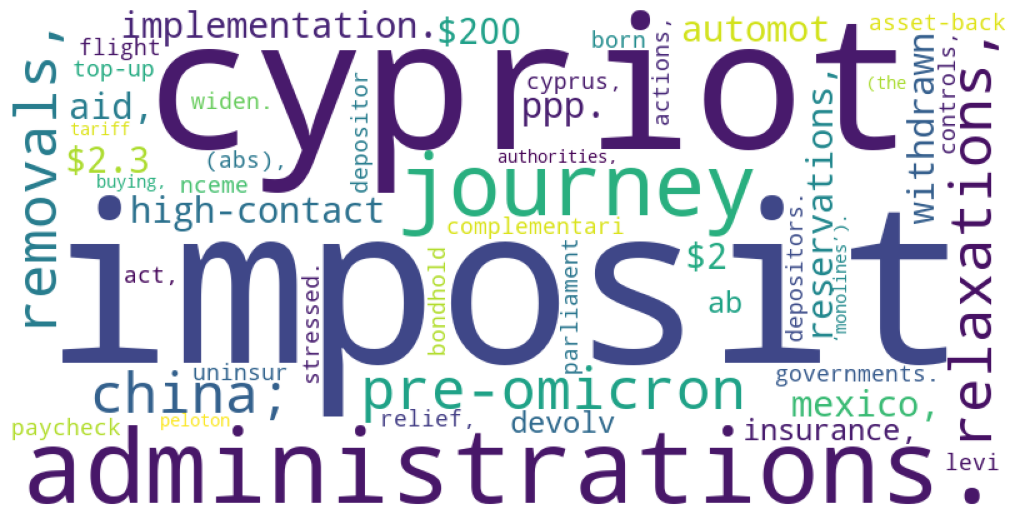

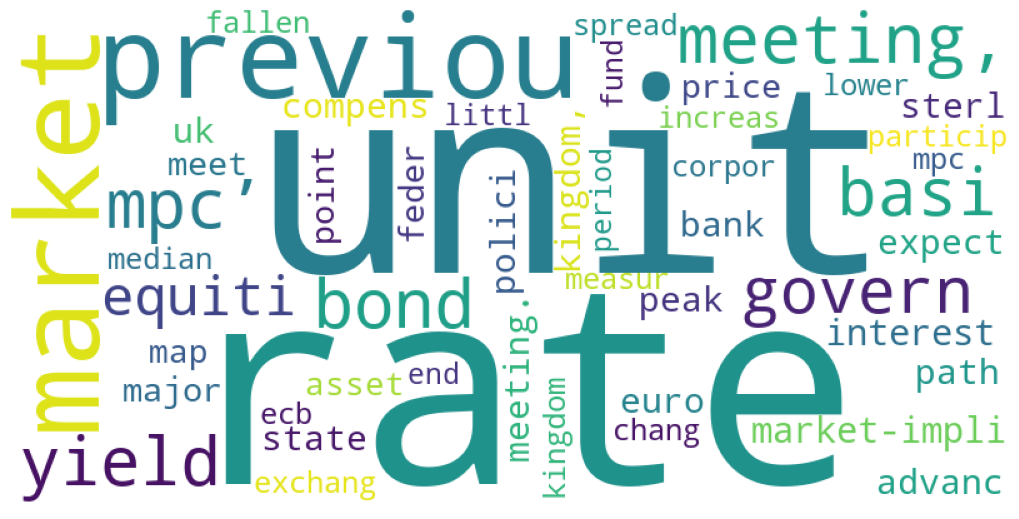

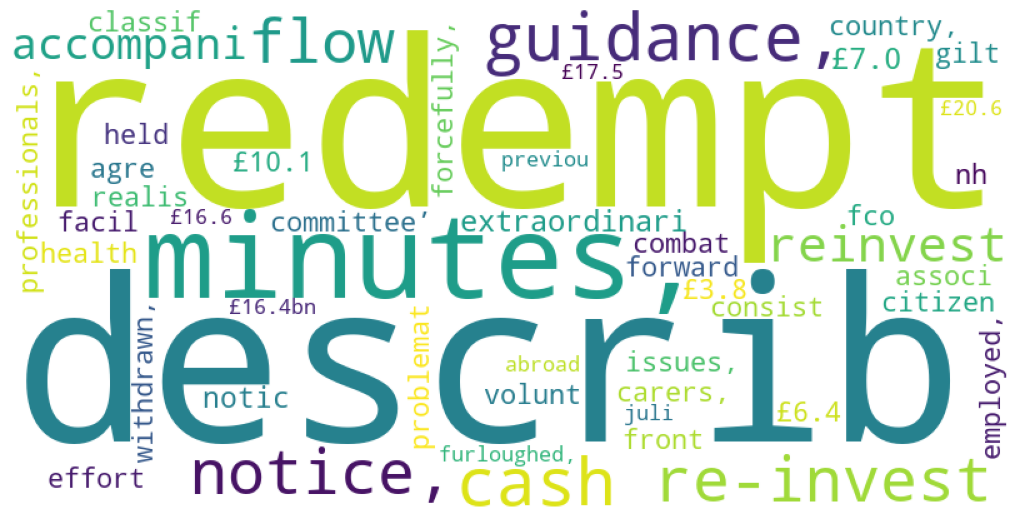

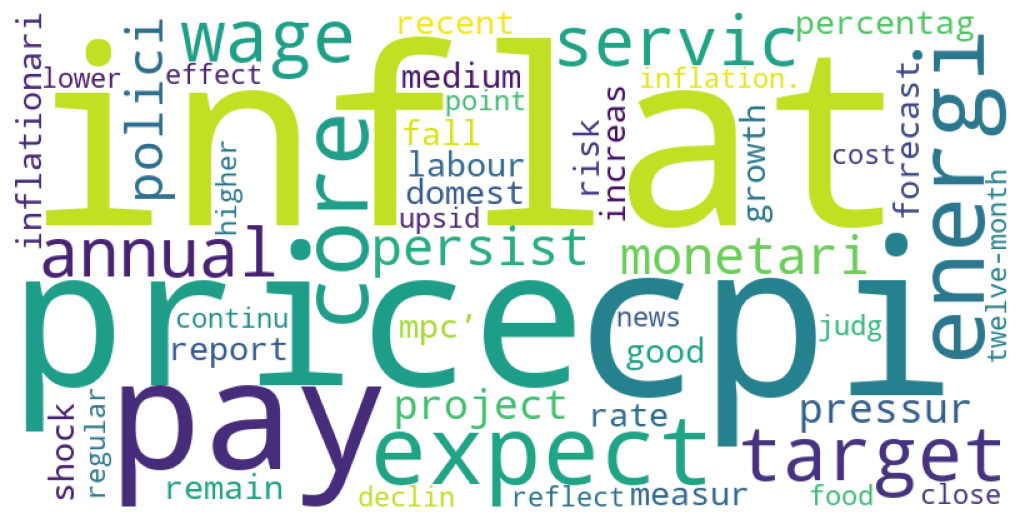

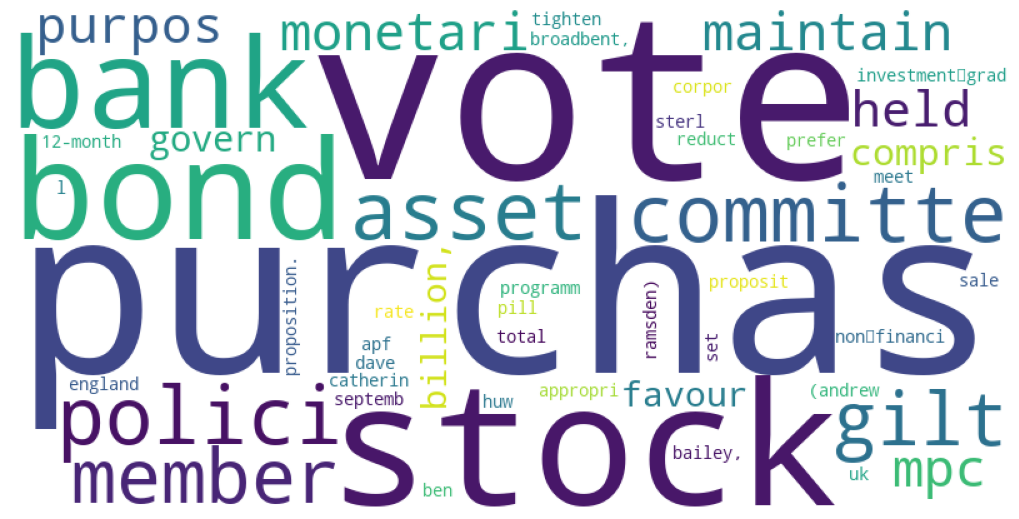

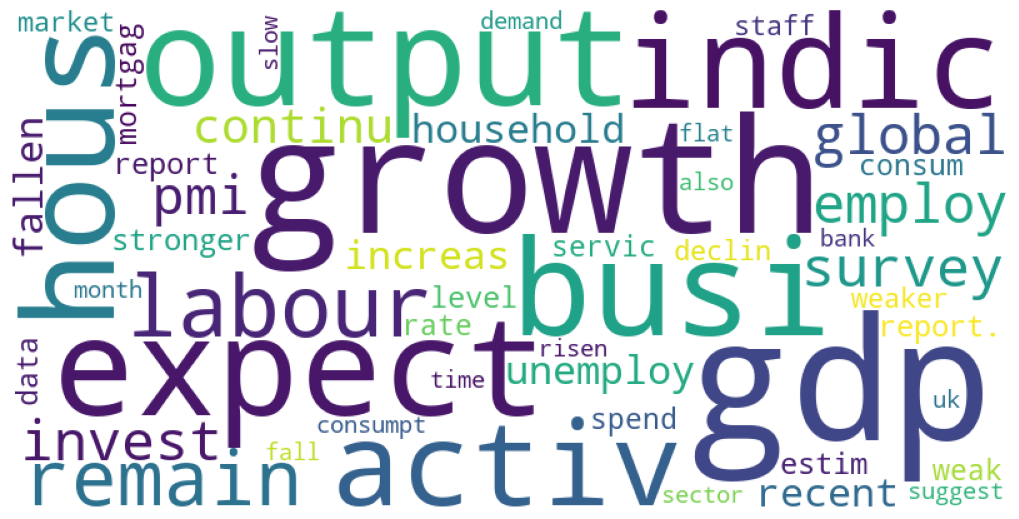

In [76]:
topic = 0 # Initialize counter
while topic < num_topics_best:
    # Get topics and frequencies and store in a dictionary structure
    topic_words_freq = dict(lda_model.show_topic(topic, topn=50)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function
    topic += 1
    
    # Generate Word Cloud for topic using frequencies
    wordcloud = WordCloud(background_color="white",width=800, height=400, random_state=7).generate_from_frequencies(topic_words_freq) 
    #plt.imshow(wordcloud, interpolation='bilinear')
    #wordcloud.to_file(image_dir+"topic_"+str(topic)+"_wordcloud.png",figsize=(10,10))
    fig, ax = plt.subplots(figsize=(10,10)) 
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    if save_figures:
        fig.savefig(\
            image_dir+"topic_"+str(topic)+"_wordcloud.png",\
                bbox_inches='tight')


In [ ]:
# adding uncertainty tone if possible -- done
# calibrating alpha, eta, number of passes and topics
# displaying words in lower dimensional space
# trying LSA if possible -- done

--------------------------------------------------

Coherence Score: 0.5768904735500023
--------------------------------------------------

Perplexity:  -8.691080153767011
--------------------------------------------------

Coherence Score: 0.6736898926233974
--------------------------------------------------

Perplexity:  -8.660186075098304
--------------------------------------------------

Coherence Score: 0.6759894829304837
--------------------------------------------------

Perplexity:  -8.648392841064904
--------------------------------------------------

Coherence Score: 0.6705787067334196
--------------------------------------------------

Perplexity:  -8.640444449084715
--------------------------------------------------

Coherence Score: 0.669912977277567
--------------------------------------------------

Perplexity:  -8.635705718631728
--------------------------------------------------

Coherence Score: 0.6712196905551705
--------------------------------------------------

P

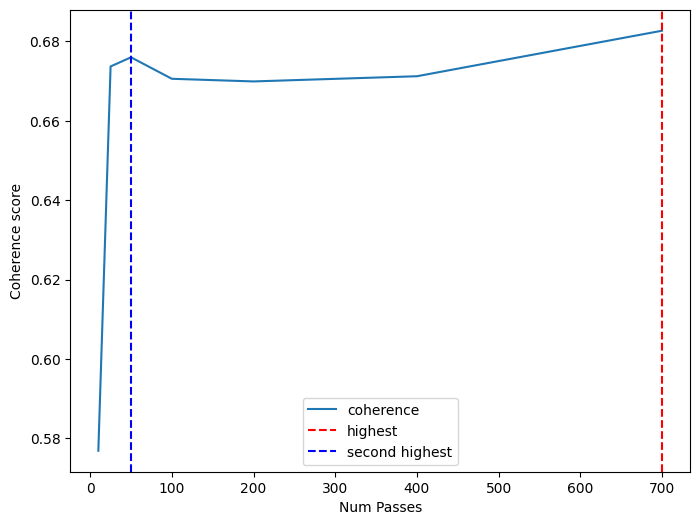

In [138]:
### TEST NUM PASSES PARAMETERS ###
lda_seed_num_passes = 400
num_topics_num_passes = 6
alpha_num_passes = 0.15
eta_num_passes = 0.32

# Plot graph of coherence values by varying num passes
num_passes_range = [10,25,50,100,200,400,700]
coherence_values_num_passes = []
model_list_num_passes = []
for num_passes in num_passes_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=num_topics_num_passes,
                            passes=num_passes,
                            alpha=alpha_num_passes,
                            eta=eta_num_passes,
                            lda_seed=lda_seed_num_passes)
    model_list_num_passes.append(lda_model)
    coherence_values_num_passes.append(coherence)

fig, ax = plt.subplots(figsize=(8,6))
num_passes_best = num_passes_range
plt.plot(num_passes_best, coherence_values_num_passes, label = "coherence")
plt.xlabel("Num Passes", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
num_pass_best = num_passes_best[np.where(coherence_values_num_passes==np.max(coherence_values_num_passes))[0][0]]
num_pass_second_best = num_passes_best[np.argsort(coherence_values_num_passes)[-2]]
plt.title('Tuning Number of Passes', fontsize=16);
plt.axvline(num_pass_best, color='r', linestyle="--", label = "highest");
plt.axvline(num_pass_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()

if save_figures:
    fig.savefig(\
        image_dir+"num_passes.png",\
            bbox_inches='tight')

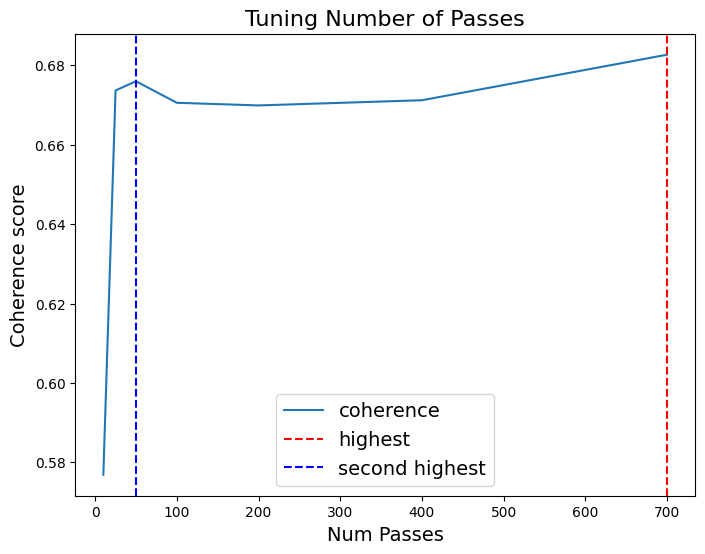

In [199]:
fig, ax = plt.subplots(figsize=(8,6))
num_passes_best = num_passes_range
plt.plot(num_passes_best, coherence_values_num_passes, label = "coherence")
plt.xlabel("Num Passes", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
num_pass_best = num_passes_best[np.where(coherence_values_num_passes==np.max(coherence_values_num_passes))[0][0]]
num_pass_second_best = num_passes_best[np.argsort(coherence_values_num_passes)[-2]]
plt.title('Tuning Number of Passes', fontsize=16);
plt.axvline(num_pass_best, color='r', linestyle="--", label = "highest");
plt.axvline(num_pass_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()

if save_figures:
    fig.savefig(\
        image_dir+"num_passes.png",\
            bbox_inches='tight')

--------------------------------------------------

Coherence Score: 0.4920693144045525
--------------------------------------------------

Perplexity:  -8.56057350712419
--------------------------------------------------

Coherence Score: 0.46747675678059475
--------------------------------------------------

Perplexity:  -8.667145411393498
--------------------------------------------------

Coherence Score: 0.6244424901326313
--------------------------------------------------

Perplexity:  -8.750727743206124
--------------------------------------------------

Coherence Score: 0.6535592473498906
--------------------------------------------------

Perplexity:  -8.81460980245485
--------------------------------------------------

Coherence Score: 0.5572826887529184
--------------------------------------------------

Perplexity:  -8.93127682688611
--------------------------------------------------

Coherence Score: 0.6121954586236839
--------------------------------------------------

Pe

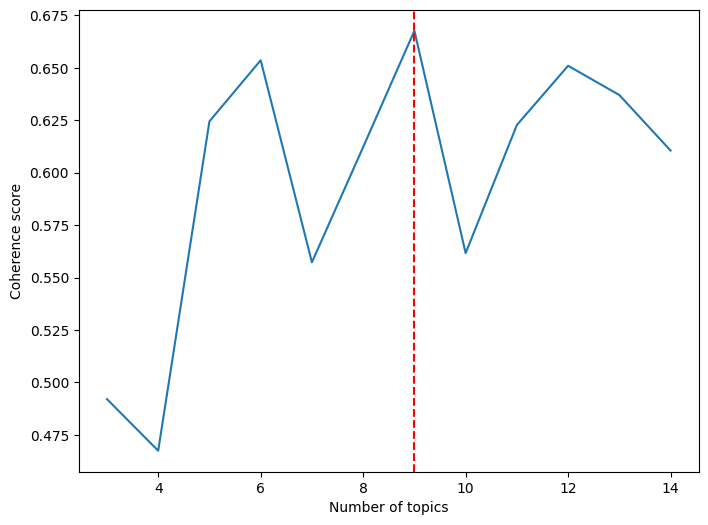

In [205]:
### FINDING A SUITABLE NUMBER OF TOPICS ###
base_alpha = 0.15
base_eta = 0.32
base_num_passes = 50
base_lda_seed = 400

limit=15; start=3; step=1;
numTopics_range = list(np.arange(start,limit, step))
coherence_values_topics = []
model_list_topics = []
for num_topics in numTopics_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=num_topics,
                            passes=base_num_passes,
                            alpha=base_alpha,
                            eta=base_eta,
                            lda_seed=base_lda_seed)
    model_list_topics.append(lda_model)
    coherence_values_topics.append(coherence)


fig, ax = plt.subplots(figsize=(8,6))
plt.plot(numTopics_range, coherence_values_topics, label = "coherence")
plt.xlabel("Number of topics", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
#plt.legend(("coherence"), loc='best')
numTopics_best = numTopics_range[np.where(coherence_values_topics==np.max(coherence_values_topics))[0][0]]
numTopics_second_best = numTopics_range[np.argsort(coherence_values_topics)[-2]]
plt.title('Tuning Number of Topics', fontsize=16);
plt.axvline(numTopics_best, color='r', linestyle="--", label = "highest");
plt.axvline(numTopics_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()

if save_figures:
    fig.savefig(\
        image_dir+"numtopics_calibration.png",\
            bbox_inches='tight')

--------------------------------------------------

Coherence Score: 0.5846559439789473
--------------------------------------------------

Perplexity:  -9.745261024277704
--------------------------------------------------

Coherence Score: 0.6371637090926016
--------------------------------------------------

Perplexity:  -8.982209838196637
--------------------------------------------------

Coherence Score: 0.5288134525794662
--------------------------------------------------

Perplexity:  -8.77154032415796
--------------------------------------------------

Coherence Score: 0.3632753160599469
--------------------------------------------------

Perplexity:  -8.736242787472213
--------------------------------------------------

Coherence Score: 0.29541762623289985
--------------------------------------------------

Perplexity:  -8.723586481722736
--------------------------------------------------

Coherence Score: 0.2862899333209182
--------------------------------------------------



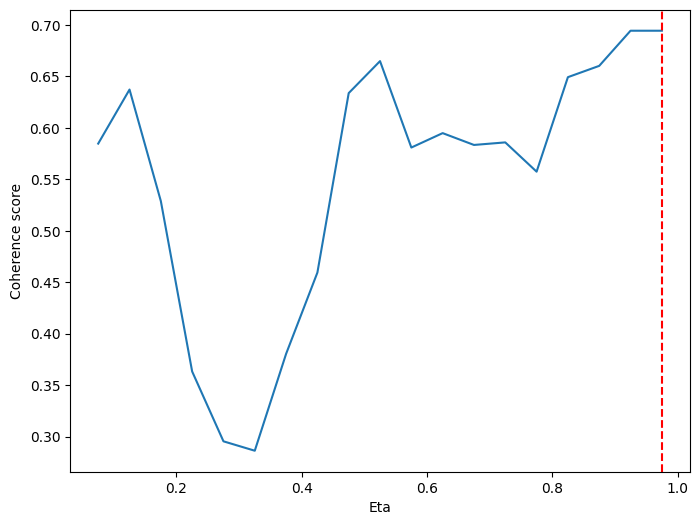

In [28]:
### FINDING A SUITABLE ETA PARAMETER ###

base_alpha = 0.15
base_num_passes = 50
base_num_topics = 6
base_lda_seed = 400

limit=0.5; start=0.075; step=0.05;
eta_range = list(np.arange(start,limit, step))
coherence_values_eta = []
model_list_eta = []
for eta in eta_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=base_num_topics,
                            passes=base_num_passes,
                            alpha=base_alpha,
                            eta=eta,
                            lda_seed=base_lda_seed)
    model_list_eta.append(lda_model)
    coherence_values_eta.append(coherence)


fig, ax = plt.subplots(figsize=(8,6))
plt.plot(eta_range, coherence_values_eta, label = "coherence")
plt.xlabel("Eta", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
eta_best = eta_range[np.where(coherence_values_eta==np.max(coherence_values_eta))[0][0]]
eta_second_best = eta_range[np.argsort(coherence_values_eta)[-2]]
plt.title('Tuning ETA Parameter', fontsize=16);
plt.axvline(eta_best, color='r', linestyle="--", label = "highest");
plt.axvline(eta_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()

if save_figures:
    fig.savefig(\
        image_dir+"eta_calibration.png",\
            bbox_inches='tight')

--------------------------------------------------

Coherence Score: 0.6530701766524846
--------------------------------------------------

Perplexity:  -8.668497388591485
--------------------------------------------------

Coherence Score: 0.6943161434190658
--------------------------------------------------

Perplexity:  -8.761391158808763
--------------------------------------------------

Coherence Score: 0.6580819726068152
--------------------------------------------------

Perplexity:  -8.838072243668455
--------------------------------------------------

Coherence Score: 0.5790636659722366
--------------------------------------------------

Perplexity:  -8.901984840912126
--------------------------------------------------

Coherence Score: 0.674318183832862
--------------------------------------------------

Perplexity:  -8.95703907454867
--------------------------------------------------

Coherence Score: 0.6116188651256774
--------------------------------------------------

Pe

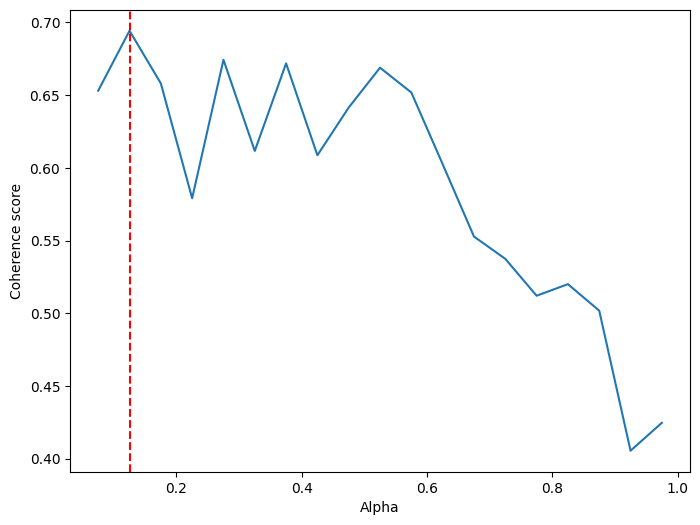

In [35]:
### FINDING A SUITABLE ALPHA PARAMETER ###

base_eta = 0.32
base_num_passes = 50
base_num_topics = 6
base_lda_seed = 400

limit=0.5; start=0.075; step=0.05;
alpha_range = list(np.arange(start,limit, step))
coherence_values_alpha = []
model_list_alpha = []
for alpha in alpha_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=base_num_topics,
                            passes=base_num_passes,
                            alpha=alpha,
                            eta=base_eta,
                            lda_seed=base_lda_seed)
    model_list_alpha.append(lda_model)
    coherence_values_alpha.append(coherence)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(alpha_range, coherence_values_alpha, label = "coherence")
plt.xlabel("Alpha", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
alpha_best = alpha_range[np.where(coherence_values_alpha==np.max(coherence_values_alpha))[0][0]]
alpha_second_best = alpha_range[np.argsort(coherence_values_alpha)[-2]]
plt.title('Tuning ALPHA Parameter', fontsize=16);
plt.axvline(alpha_best, color='r', linestyle="--", label = "highest");
plt.axvline(alpha_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()

if save_figures:
    fig.savefig(\
        image_dir+"alpha_calibration.png",\
            bbox_inches='tight')

--------------------------------------------------

Coherence Score: 0.577542550109634
--------------------------------------------------

Perplexity:  -9.035145044244485
--------------------------------------------------

Coherence Score: 0.6009403973478178
--------------------------------------------------

Perplexity:  -9.09453538954791
--------------------------------------------------

Coherence Score: 0.5461687043124259
--------------------------------------------------

Perplexity:  -9.026731115245354
--------------------------------------------------

Coherence Score: 0.60753071305871
--------------------------------------------------

Perplexity:  -8.981709061872781
--------------------------------------------------

Coherence Score: 0.6465598315347016
--------------------------------------------------

Perplexity:  -9.045869107272011
--------------------------------------------------

Coherence Score: 0.6364472939454219
--------------------------------------------------

Perp

IndexError: list index out of range

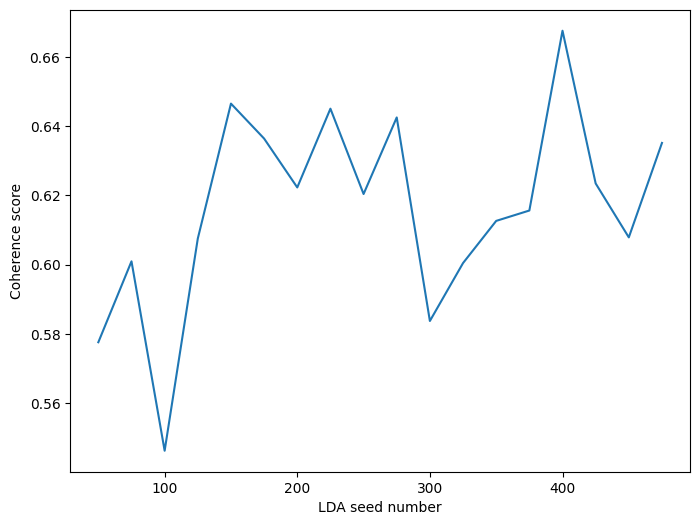

In [233]:
### FINDING A SUITABLE LDA SEED NUMBER PARAMETER ###

base_eta = 0.15
base_alpha = 0.32
base_num_passes = 50
base_num_topics = 6

limit=500; start=50; step=25;
lda_seed_range = list(np.arange(start,limit, step))
coherence_values_seed = []
model_list_seed = []
for lda_seed_var in lda_seed_range:
    lda_model, coherence = run_lda(corpus_tfidf, id2word,
                            num_topics=base_num_topics,
                            passes=base_num_passes,
                            alpha=base_alpha,
                            eta=base_eta,
                            lda_seed=lda_seed_var)
    model_list_seed.append(lda_model)
    coherence_values_seed.append(coherence)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(lda_seed_range, coherence_values_seed, label = "coherence")
plt.xlabel("LDA seed number", fontsize=14)
plt.ylabel("Coherence score", fontsize=14)
lda_seed_best = lda_seed_range[np.where(coherence_values_seed==np.max(coherence_values_seed))[0][0]]
lda_seed_second_best = lda_seed_range[np.argsort(coherence_values_seed)[-2]]
plt.title('Tuning LDA SEED Number', fontsize=16);
plt.axvline(lda_seed_best, color='r', linestyle="--", label = "highest");
plt.axvline(lda_seed_second_best, color='b', linestyle="--", label = "second highest");
plt.legend(loc='best', fontsize=14)
plt.show()

if save_figures:
    fig.savefig(\
        image_dir+"ldaseed_calibration.png",\
            bbox_inches='tight')

#### Junk

In [111]:
from gensim.corpora import Dictionary

texts = [['human', 'interface', 'computer']]
dct = Dictionary(texts)  # initialize a Dictionary
dct.add_documents([["cat", "say", "meow"], ["dog"]])  # add more document (extend the vocabulary)
print(dct.doc2bow(["dog", "computer", "non_existent_word"]))
#[(0, 1), (6, 1)]
print(dct.keys())

[(0, 1), (6, 1)]
[0, 1, 2, 3, 4, 5, 6]


In [97]:
def save_data_serialized(obj_to_save, name_of_file):
    fileObj = open('serialized_data/'+name_of_file+'.obj', 'wb')
    pickle.dump(obj_to_save,fileObj)
    fileObj.close()


def load_serialized_data(obj_names):
    objects = []
    for obj_name in obj_names:
        fileObj = open('serialized_data/'+obj_name+'.obj', 'rb')
        objects.append(pickle.load(fileObj))
        fileObj.close()
    return objects


save_data_serialized(docs_tokens_list,"docs_tok_filtered_aslist")
load_serialized_data(["docs_tok_filtered_aslist"])

[[['condit',
   'deterior',
   'rang',
   'financi',
   'market',
   'month',
   'spread',
   'number',
   'asset',
   'back',
   'secur',
   'widen',
   'partli',
   'prompt',
   'downgrad',
   'rate',
   'agenc',
   'declin',
   'valu',
   'secur',
   'seri',
   'announc',
   'bank',
   'accentu',
   'concern',
   'distribut',
   'scale',
   'possibl',
   'loss',
   'recent',
   'financi',
   'market',
   'turmoil'],
  ['heighten',
   'concern',
   'increas',
   'investor',
   'percept',
   'risk',
   'associ',
   'individu',
   'bank',
   'evidenc',
   'higher',
   'premia',
   'credit',
   'default',
   'swap',
   'also',
   'contribut',
   'sharp',
   'tighten',
   'money',
   'market',
   'condit',
   'spread',
   'inter',
   'bank',
   'lend',
   'rate',
   'expect',
   'polici',
   'rate',
   'rise',
   'substanti',
   'novemb',
   'credit',
   'risk',
   'appear',
   'factor',
   'recent',
   'increas',
   'inter',
   'bank',
   'lend',
   'rate',
   'contrast',
   'develop',


In [78]:
file_name1 = "files/2021-08-05_boe_minutes.txt"
file_name2 = "files/2022-02-03_boe_minutes.txt"
file_name3 = "files/2015-08-06_boe_minutes.txt"
file_name4 = "files/2011-01-13_boe_minutes.txt"

infile1 = open(file_name1, 'r')
infile2 = open(file_name2, 'r')
infile3 = open(file_name3, 'r')
infile4 = open(file_name4, 'r')

#Store the data from the file in a variable
data1 = infile1.read()
data2 = infile2.read()
data3 = infile3.read()
data4 = infile4.read()


#close the file
infile1.close()
infile2.close()
infile3.close()
infile4.close()

In [80]:
current_doc = data2
current_doc = re.sub('\n *\d+ *\n', '', current_doc, flags=re.DOTALL)
current_doc  = str.lower(current_doc)
"before turning" in current_doc
current_doc = re.sub('(.*)(?=before turning)', '', current_doc, flags=re.DOTALL)
current_doc

#test = '.\n 2\n5 overall, the re-pricing of assets suggested that there had been a general re-evaluation of risk.\nwere that to continue, it could lead to further falls in asset prices, posing further downside risks to the\neconomy.\n6 '
# remove numbers on line (page number)
all_documents = re.findall('\n\d+[:)\.]? (.+?)(?=\.?\n\n\d|\.?\n\n|\.?\n\d+ )', current_doc, flags=re.DOTALL)
print(len(all_documents))
a  = [(i,all_documents[i]) for i in range(len(all_documents))]
a
#print(str(a))
#all_titles = re.findall('(\w+\s){1,4}', "asdf sd sd sd asa f", flags=re.DOTALL)
#all_titles

67


[(0,
  "uk-weighted global gdp was estimated to have grown by 0.8% in 2021 q4, as had been expected in the november monetary policy report. in 2022 q1, global gdp was expected to grow more slowly than had been anticipated in the november report, as the omicron covid variant had led to renewed restrictions and voluntary social distancing in many countries. however, the uncertainty relating to the economic impact of omicron had declined, and its economic consequences were likely to be more limited and of shorter duration than had been anticipated at the time of the mpc's december meeting. global cost pressures, arising from the strength in goods demand and supply chain disruptions as well as high energy prices, had remained elevated and had also weighed on activity over past months. strong demand for goods, in particular in the united states, had appeared to have been a more important determinant of global bottlenecks than supply chain disruptions over recent months"),
 (1,
  'according 

In [13]:
# Clean text - stage 2, using regex (as SpaCy incorrectly parses certain HTML tags)    
minsTxt = re.sub(r'(<[^>]*>)|' # Remove content within HTML tags
                    '([_]+)|' # Remove series of underscores
                    '(http[^\s]+)|' # Remove website addresses
                    '((a|p)\.m\.)', # Remove "a.m" and "p.m."
                    '', data1[130:3000]) # Replace with null
minsTxt

' Monetary Policy Committee meeting held on\n6 & 7 February 2008.\nThey are also available on the Internet\n\nThe Bank of England Act 1998 gives the Bank of England operational responsibility\nfor setting interest rates to meet the Government’s inflation target. Operational\ndecisions are taken by the Bank’s Monetary Policy Committee. The Committee meets\non a regular monthly basis and minutes of its meetings are released on the\nWednesday of the second week after the meeting takes place. Accordingly, the\nminutes of the Committee meeting held on 5 and 6 March will be published on\n19 March 2008.\n\n\nMINUTES OF THE MONETARY POLICY COMMITTEE MEETING HELD\nON 6-7 FEBRUARY 2008\n1 Before turning to its immediate policy decision, and against the background of its latest\nprojections for output and inflation, the Committee discussed financial markets developments; the\ninternational economy; credit, demand and output; and costs and prices.\nFinancial markets\n2 Financial markets had contin

In [ ]:
boe_dates = pd.read_csv("boe_meeting_dates.txt").apply(lambda x: dt.strptime(x["date"], "%d-%b-%y"),axis=1)
boe_dates[0].date().strftime("%d-%m-%Y")

In [ ]:
import os
def touch(path):
    with open(path, 'a'):
        os.utime(path, None)

#for date in boe_dates:
#    datestr = date.strftime("%Y-%m-%d")
#    filename = "./files/"+datestr+"_boe_statement.txt"
#    touch(filename)
#    filename = "./files/"+datestr+"_boe_minutes.txt"
#    touch(filename)